In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import fully_connected as fc
#from sklearn.manifold import TSNE

from ThemeSeacher import Updator, clean, PhraserModel, tokenizer
from ThemeSeacher import KeywordDict, Model, Extractor
from ThemeSeacher import EmbeddingModel, Clustering

/home/qara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Embedding default loaded


In [4]:
phraser = PhraserModel().get_phraser
dic = KeywordDict(phraser=phraser).get_dict

phraser_default.bin  loaded
keyword dictionary loaded


# Pickle Functions

In [3]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


# Embedding

In [4]:
embedding = EmbeddingModel().get_embedding

Embedding default loaded


In [5]:
train_data = load_obj('seq2seq_embed')
len(train_data)

557440

# Generator

In [6]:
def generator(data, bs):
    np.random.shuffle(data)
    for i in range(len(data)//bs):
        batch = data[bs*i: bs*(i+1)]

        x_gen = list(map(lambda k: np.pad(k, \
                ((40-len(k),0),(0,0)),'constant'), batch))
        mask_gen = list(map(lambda k: np.array(\
                [0 for i in range(40-len(k))] + \
                [1 for j in range(len(k))]), batch))

        yield np.array(list(x_gen)), np.array(list(mask_gen))

# Model

In [1]:
class mixmodel(object):
    def __init__(self, n_z=4, sigma=1e-3, lr_1=1e-3, lr_2=1e-4, alpha=1, beta=1):
        self.title_len = 40
        self.em_dim = 100
        self.hidden_dim = 100
        
        self.n_z = n_z
        self.beta = beta
        self.sigma = sigma
    
        self.x = tf.placeholder(tf.float32, [None, self.title_len, self.em_dim])
        self.mask = tf.placeholder(tf.float32, [None, self.title_len])
        
        self.x_len = tf.reduce_sum(self.mask, axis=1)
    
        ### Seq2seq Encoder ###
        # seq -> embed
        self.sentence_embed = self.s2s_encoder(self.x)
        
        # embed -> recon_embed
        self.x_recon = self.s2s_decoder(self.sentence_embed)
        
        ### VAE Encoder ###
        # embed -> z_mean, z_sigma -> z
        self.z_mu, self.z_log_sigma_sq = self.vae_encoder(self.sentence_embed)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=self.sigma, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        ### VAE Decoder ###
        # z -> embed_hat
        self.sentence_embed_hat = self.vae_decoder(self.z)

        ### Seq2seq Decoder ###
        # embed_hat -> seq_hat
        self.x_gen = self.s2s_decoder(self.sentence_embed_hat)
        
        t_vars = tf.trainable_variables()
        s2s_vars = [v for v in t_vars if 's2s' in v.name]
        vae_vars = [v for v in t_vars if 'vae' in v.name]
        
        
        ## Seq2Seq Loss ##
        # Reconstruction loss
        s2s_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_recon), axis=2)
        
        self.s2s_loss = tf.reduce_mean(tf.reduce_sum(s2s_l2_loss * self.mask, axis=1)/self.x_len)
        self.s2s_train = tf.train.AdamOptimizer(learning_rate=lr_1).minimize(self.s2s_loss, var_list=s2s_vars)
        
        ## VAE Loss ##
        # Embedding L2 loss
        self.embed_loss = tf.reduce_mean(tf.squared_difference(self.sentence_embed, self.sentence_embed_hat))
        
        # Reconstruction loss
        vae_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_gen), axis=2)
        self.l2_loss = alpha * tf.reduce_mean(tf.reduce_sum(vae_l2_loss * self.mask, axis=1)/self.x_len)
        
        # Latent loss : Kullback Leibler divergence
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.beta * tf.reduce_mean(latent_loss)
        
        self.vae_loss = self.embed_loss + self.l2_loss + self.latent_loss
        self.vae_train = tf.train.AdamOptimizer(learning_rate=lr_2).minimize(self.vae_loss, var_list = vae_vars)    
    
    def s2s_encoder(self, x):
        encoder_cell = tf.contrib.rnn.LSTMCell(self.hidden_dim)
        encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
            encoder_cell, 
            x,
            dtype=tf.float32, 
            time_major=False,
            scope="s2s_encoder",
        )
        return encoder_final_state[1]
    
    def s2s_decoder(self, sentence_embed):
        with tf.variable_scope('s2s_decoder', reuse=tf.AUTO_REUSE):
            s_code = tf.reshape(sentence_embed, [-1, 1, self.hidden_dim])
            decoder_cell = tf.contrib.rnn.LSTMCell(self.em_dim)
            decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                decoder_cell, 
                tf.tile(s_code, [1, self.title_len, 1]),
                initial_state = tf.contrib.rnn.LSTMStateTuple(sentence_embed, sentence_embed),
                dtype=tf.float32, 
                time_major=False, 
                #scope="s2s_decoder",
            )
        
        return tf.reverse(decoder_outputs, [1])
    
    def vae_encoder(self, x):
        f1 = fc(x, 128, scope='vae_enc_fc1', activation_fn=tf.nn.elu)
        f1 = slim.batch_norm(f1, scope='vae_enc_fc1')
        f2 = fc(f1, 128, scope='vae_enc_fc2', activation_fn=tf.nn.elu)
        f2 = slim.batch_norm(f2, scope='vae_enc_fc2')
        f3 = fc(f2, 64, scope='vae_enc_fc3', activation_fn=tf.nn.elu)
        f3 = slim.batch_norm(f3, scope='vae_enc_fc3')
        f4 = fc(f3, 32, scope='vae_enc_fc4', activation_fn=tf.nn.elu)
        f4 = slim.batch_norm(f4, scope='vae_enc_fc4')
        f5 = fc(f4, 32, scope='vae_enc_fc5', activation_fn=tf.nn.elu)
        f5 = slim.batch_norm(f5, scope='vae_enc_fc5')
        f6 = fc(f5, 16, scope='vae_enc_fc6', activation_fn=tf.nn.elu)
        f6 = slim.batch_norm(f6, scope='vae_enc_fc6')
        f7 = fc(f6, 16, scope='vae_enc_fc7', activation_fn=tf.nn.elu)
        f7 = slim.batch_norm(f7, scope='vae_enc_fc7')
        f8 = fc(f7, 8, scope='vae_enc_fc8', activation_fn=tf.nn.elu)
        f8 = slim.batch_norm(f8, scope='vae_enc_fc8')
        f9 = fc(f8, 8, scope='vae_enc_fc9', activation_fn=tf.nn.elu)
        f9 = slim.batch_norm(f9, scope='vae_enc_fc9')
        f10 = fc(f9, 4, scope='vae_enc_fc10', activation_fn=tf.nn.elu)
        f10 = slim.batch_norm(f10, scope='vae_enc_fc10')
        z_mu = fc(f10, self.n_z, scope='vae_enc_fc11_mu', activation_fn=None)
        z_log_sigma_sq = fc(f10, self.n_z, scope='vae_enc_fc11_sigma', activation_fn=None)
        
        return z_mu, z_log_sigma_sq
    
    def vae_decoder(self, z):
        g1 = fc(z, 4, scope='vae_dec_fc1', activation_fn=tf.nn.elu)
        g1 = slim.batch_norm(g1, scope='vae_dec_fc1')
        g2 = fc(g1, 8, scope='vae_dec_fc2', activation_fn=tf.nn.elu)
        g2 = slim.batch_norm(g2, scope='vae_dec_fc2')
        g3 = fc(g2, 8, scope='vae_dec_fc3', activation_fn=tf.nn.elu)
        g3 = slim.batch_norm(g3, scope='vae_dec_fc3')
        g4 = fc(g3, 16, scope='vae_dec_fc4', activation_fn=tf.nn.elu)
        g4 = slim.batch_norm(g4, scope='vae_dec_fc4')
        g5 = fc(g4, 16, scope='vae_dec_fc5', activation_fn=tf.nn.elu)
        g5 = slim.batch_norm(g5, scope='vae_dec_fc5')
        g6 = fc(g5, 32, scope='vae_dec_fc6', activation_fn=tf.nn.elu)
        g6 = slim.batch_norm(g6, scope='vae_dec_fc6')
        g7 = fc(g6, 32, scope='vae_dec_fc7', activation_fn=tf.nn.elu)
        g7 = slim.batch_norm(g7, scope='vae_dec_fc7')
        g8 = fc(g7, 64, scope='vae_dec_fc8', activation_fn=tf.nn.elu)
        g8 = slim.batch_norm(g8, scope='vae_dec_fc8')
        g9 = fc(g8, 64, scope='vae_dec_fc9', activation_fn=tf.nn.elu)
        g9 = slim.batch_norm(g9, scope='vae_dec_fc9')
        g10 = fc(g9, 100, scope='vae_dec_fc10', activation_fn=tf.nn.elu)
        g10 = slim.batch_norm(g10, scope='vae_dec_fc10')
        sentence_embed_hat = fc(g10, 100, scope='vae_dec_fc11', activation_fn=None)
        
        return sentence_embed_hat
    

In [2]:
tf.reset_default_graph()
model = mixmodel(n_z=4, sigma=1e-2, lr_1=1e-3, lr_2=1e-4, alpha=10, beta=1)

tfconfig = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess=tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

NameError: name 'tf' is not defined

### Load Model

In [51]:
model_name = 'vae_20'
#model_name = 'seq2seq_40'
saver = tf.train.Saver()
saver.restore(sess, './ckpt_bn/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt_bn/vae_20.ckpt


### Training Seq2seq

In [22]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=100
save_step=5

saver = tf.train.Saver(max_to_keep=20)

for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    
    for batch in generator(train_data, bs):
        loss , _ = sess.run([model.s2s_loss, model.s2s_train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        
        avg_loss += loss
        
        count += 1
        if count%print_step==0:
            print('steps-%d / total loss: %.4f'\
                 %(count, avg_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_bn/seq2seq_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps-100 / total loss: 0.0653
steps-200 / total loss: 0.0618
steps-300 / total loss: 0.0596
steps-400 / total loss: 0.0581
steps-500 / total loss: 0.0570
Epoch: [2/100]
steps-100 / total loss: 0.0512
steps-200 / total loss: 0.0508
steps-300 / total loss: 0.0505
steps-400 / total loss: 0.0503
steps-500 / total loss: 0.0501
Epoch: [3/100]
steps-100 / total loss: 0.0487
steps-200 / total loss: 0.0485
steps-300 / total loss: 0.0484
steps-400 / total loss: 0.0483
steps-500 / total loss: 0.0482
Epoch: [4/100]
steps-100 / total loss: 0.0474
steps-200 / total loss: 0.0473
steps-300 / total loss: 0.0472
steps-400 / total loss: 0.0472
steps-500 / total loss: 0.0471
Epoch: [5/100]
steps-100 / total loss: 0.0466
steps-200 / total loss: 0.0465
steps-300 / total loss: 0.0464
steps-400 / total loss: 0.0464
steps-500 / total loss: 0.0463
Epoch: [6/100]
steps-100 / total loss: 0.0459
steps-200 / total loss: 0.0459
steps-300 / total loss: 0.0459
steps-400 / total loss: 0.0459
steps-500 /

KeyboardInterrupt: 

### Training VAE

In [45]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=100
save_step=5

saver = tf.train.Saver(max_to_keep=20)

for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    avg_embed_loss = 0
    avg_l2_loss = 0
    avg_latent_loss = 0
    
    for batch in generator(train_data, bs):
        loss, e_loss, l2_loss, l_loss , _ = sess.run([model.vae_loss, \
                model.embed_loss, model.l2_loss, model.latent_loss, model.vae_train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        
        avg_loss += loss
        avg_embed_loss += e_loss
        avg_l2_loss += l2_loss
        avg_latent_loss += l_loss
        
        count += 1
        if count%print_step==0:
            print('steps-%d\ntotal loss: %.4f, embed: %.4f, l2: %.4f, latent: %.4f'\
                 %(count, avg_loss/count, avg_embed_loss/count, avg_l2_loss/count, avg_latent_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_bn/vae_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps-100
total loss: 5.2233, embed: 0.8289, l2: 1.5239, latent: 2.8705
steps-200
total loss: 4.3706, embed: 0.6078, l2: 1.2813, latent: 2.4815
steps-300
total loss: 3.9106, embed: 0.4879, l2: 1.1620, latent: 2.2607
steps-400
total loss: 3.6080, embed: 0.4174, l2: 1.0886, latent: 2.1020
steps-500
total loss: 3.3814, embed: 0.3714, l2: 1.0380, latent: 1.9720
Epoch: [2/100]
steps-100
total loss: 2.1738, embed: 0.1678, l2: 0.8050, latent: 1.2010
steps-200
total loss: 2.0935, embed: 0.1625, l2: 0.7979, latent: 1.1331
steps-300
total loss: 2.0207, embed: 0.1575, l2: 0.7917, latent: 1.0715
steps-400
total loss: 1.9547, embed: 0.1524, l2: 0.7860, latent: 1.0163
steps-500
total loss: 1.8942, embed: 0.1474, l2: 0.7806, latent: 0.9662
Epoch: [3/100]
steps-100
total loss: 1.5083, embed: 0.1106, l2: 0.7447, latent: 0.6530
steps-200
total loss: 1.4685, embed: 0.1051, l2: 0.7404, latent: 0.6230
steps-300
total loss: 1.4301, embed: 0.0995, l2: 0.7358, latent: 0.5948
steps-400
total los

KeyboardInterrupt: 

# Evaluation

In [24]:
def generate_seq2seq(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    tf.reset_default_graph()
    output = sess.run(model.x_recon, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

In [25]:
def generate_vae(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    tf.reset_default_graph()
    output = sess.run(model.x_gen, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

def sentence_embed(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((40-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(40-len(embed))] + [1 for i in range(len(embed))])
    
    tf.reset_default_graph()
    output = sess.run([model.sentence_embed, model.sentence_embed_hat],\
                       feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][0], output[1][0]

In [29]:
total_data = load_obj('total_data')

idx = total_data.groupby(['date'])['score'].transform(max) == total_data['score']
top_news = total_data[idx].sort_values(by=['date'])

hot_news = total_data[total_data.score>=1000]
common_news = total_data[total_data.score==0]

top_news = top_news.reset_index(drop=True)
hot_news = hot_news.sort_values(by='date').reset_index(drop=True)
common_news = common_news.sort_values(by='date').reset_index(drop=True)

In [52]:
index = 4
test_s2s = generate_seq2seq(top_news.lemmatized[index], model)
test_vae = generate_vae(top_news.lemmatized[index], model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
print(top_news.lemmatized[index])

['north', 'korea', 'open', 'economy', 'foreign', 'investment', 'year', 'support', 'german', 'economic', 'legal', 'expert', 'interested', 'vietnamese', 'model']


In [54]:
for i in range(len(test_s2s)):
    print(top_news.lemmatized[index][i])
    print(embedding.similar_by_vector(test_s2s[i]))
    print(embedding.similar_by_vector(test_vae[i]))
    print()

north
[('western', 0.7431484460830688), ('india', 0.7422326803207397), ('germany', 0.7284787893295288), ('australia', 0.7264530062675476), ('country', 0.7251840829849243), ('indian', 0.7228765487670898), ('european', 0.7145323157310486), ('south', 0.7086613178253174), ('japan', 0.69948410987854), ('america', 0.6982531547546387)]
[('protest', 0.7639952898025513), ('restore_diplomatic', 0.761128306388855), ('innocent_bystander', 0.7572382092475891), ('destroy_islamic', 0.7559887170791626), ('confrontation_swedish', 0.7506969571113586), ('iranian', 0.7500051259994507), ('libyan_dictator', 0.7491512298583984), ('crimean', 0.7486168146133423), ('invite', 0.7466554641723633), ('insist', 0.7455788850784302)]

korea
[('country', 0.7732845544815063), ('diplomatic_relation', 0.7691455483436584), ('resolve_diplomatically', 0.7633846998214722), ('nuclear_umbrella', 0.76046222448349), ('britain', 0.7597438097000122), ('vietnam', 0.7540197372436523), ('diplomatically', 0.7532918453216553), ('communi

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


In [55]:
index = 1
test_s2s = generate_seq2seq(total_data.lemmatized[index], model)
test_vae = generate_vae(total_data.lemmatized[index], model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
print(total_data.lemmatized[index])

['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']


In [57]:
for i in range(len(test_s2s)):
    print(total_data.lemmatized[index][i])
    similar_s2s = embedding.similar_by_vector(test_s2s[i])
    words, similarities = zip(*similar_s2s)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_s2s = zip(words, similarities)
    
    similar_vae = embedding.similar_by_vector(test_vae[i])
    words, similarities = zip(*similar_vae)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_vae = zip(words, similarities)
    print(list(similar_s2s))
    print(list(similar_vae))
    print()

president
[('president_obama', 0.81), ('obama', 0.8), ('supporter', 0.79), ('socialist', 0.79), ('politician', 0.79), ('insist', 0.79), ('political_liberalization', 0.78), ('communist_dictator', 0.78), ('invite', 0.77), ('democratically_elect', 0.77)]
[('protest', 0.77), ('restore_diplomatic', 0.76), ('innocent_bystander', 0.76), ('destroy_islamic', 0.76), ('invite', 0.75), ('confrontation_swedish', 0.75), ('insist', 0.75), ('libyan_dictator', 0.75), ('crimean', 0.75), ('iranian', 0.75)]

obama
[('obama', 0.88), ('barack_obama', 0.86), ('politician', 0.85), ('unfeminist', 0.83), ('politician_journalist', 0.83), ('president_obama', 0.83), ('frist', 0.82), ('self_righteously', 0.82), ('supporter', 0.82), ('liberal', 0.82)]
[('protest', 0.76), ('restore_diplomatic', 0.75), ('confrontation_swedish', 0.75), ('invite', 0.75), ('innocent_bystander', 0.75), ('destroy_islamic', 0.74), ('insist', 0.74), ('iranian', 0.74), ('crimean', 0.74), ('libyan_dictator', 0.74)]

want
[('remind', 0.75), ('e

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


# Distribution

In [216]:
def generate_from_df(df):
    x = []
    mask = []
    for idx, row in df.iterrows():
        title = list(row.lemmatized)
        title = [x for x in title if len(x)!=1]
        if len(title)>40:
            title = title[:40]

        k = embedding[title]
        x.append(np.pad(k, ((40-len(k),0), (0,0)), 'constant'))
        mask.append(np.array([0 for i in range(40-len(k))] + [1 for i in range(len(k))]))
        
    yield np.array(list(x)), np.array(list(mask))

def extract_code(df, bs=0):
    codes = []
    c=0
    if bs==0:
        bs = len(df)
    if len(df)==0:
        return
    for i in range((len(df))//bs):
    #for i in range((len(df)+bs-1)//bs):
        small_df = df[bs*i:bs*(i+1)]
        for x, mask in generate_from_df(small_df):
            c += 1
            code = sess.run(model.z_mu, feed_dict={
                model.x: x, model.mask: mask
            })
            codes.append(code)

            if c*bs%1000==0:
                print(c*bs)
    codes = np.array(list(codes))
    codes = np.reshape(codes, [-1, 4])
    return codes

def show_embeds(codes, size=10):
    colors = cm.rainbow(np.linspace(1, 0, len(codes)))
    fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
    x1 = codes[:, 0]
    for idx in range(1, model.n_z):
        y1 = codes[:, idx]
        #ax[idx-1].set_xlim(-0.15, 0.15)
        #ax[idx-1].set_ylim(-0.15, 0.15)
        ax[idx-1].scatter(x1, y1, color=colors, s=5)

    plt.show()

### Average Log Embedding

In [ ]:
total_data = load_obj('upper1')

In [203]:
startt = time.time()
c = 0
average_codes = []
for date in pd.date_range('2013-01-01', '2018-06-01'):
    c += 1
    if c%200 == 0:
        print(day_code)
        print(c, 'steps -', time.time()-startt, 'sec')
    
    df_day = total_data[total_data.date.apply(str) == date.strftime('%Y-%m-%d')].reset_index(drop=True)
    if len(df_day)==0:
        print(date)
        continue
    
    upcount = 0
    day_code = np.zeros(4, dtype=np.float32)
    codes = extract_code(df_day)
    '''
    #print('codes', type(codes))
    upscores = np.log(list(df_day.score)).reshape(-1,1).transpose()
    #print('upcores', type(upscores))
    
    day_code = np.matmul(upscores, codes)
    upcount = np.sum(upscores)
    '''
    for index in range(len(df_day)):
        upscore = np.log(df_day.score[index])
        upcount += upscore
        day_code += upscore * codes[index]
    
    day_code /= upcount
    average_codes.append(day_code)
    #new_df.loc[ni, 'embed'] = sentence_embedding
    #new_df.loc[ni, 'embed_log'] = sentence_embedding
    #new_df.loc[ni, 'embed_exp'] = sentence_embedding

print('Done.')

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


2013-02-02 00:00:00
2013-02-03 00:00:00
2013-02-04 00:00:00
2013-02-05 00:00:00
2013-02-06 00:00:00
2013-02-07 00:00:00
2013-02-08 00:00:00
2013-02-09 00:00:00
2013-02-10 00:00:00
2013-02-11 00:00:00
2013-02-12 00:00:00
2013-02-13 00:00:00
2013-02-14 00:00:00
2013-02-15 00:00:00
2013-02-16 00:00:00
2013-02-17 00:00:00
2013-02-18 00:00:00
2013-02-19 00:00:00
2013-02-20 00:00:00
2013-02-21 00:00:00
2013-02-22 00:00:00
2013-02-23 00:00:00
2013-02-24 00:00:00
2013-02-25 00:00:00
2013-02-26 00:00:00
2013-02-27 00:00:00
2013-02-28 00:00:00
2013-03-01 00:00:00
2013-03-02 00:00:00
2013-03-03 00:00:00
2013-03-04 00:00:00
2013-03-05 00:00:00
2013-03-06 00:00:00
2013-03-07 00:00:00
2013-03-08 00:00:00
2013-03-09 00:00:00
2013-03-10 00:00:00
2013-03-11 00:00:00
2013-03-12 00:00:00
2013-03-13 00:00:00
2013-03-14 00:00:00
2013-03-15 00:00:00
2013-03-16 00:00:00
2013-03-17 00:00:00
2013-03-18 00:00:00
2013-03-19 00:00:00
2013-03-20 00:00:00
2013-03-21 00:00:00
2013-03-22 00:00:00
2013-03-23 00:00:00


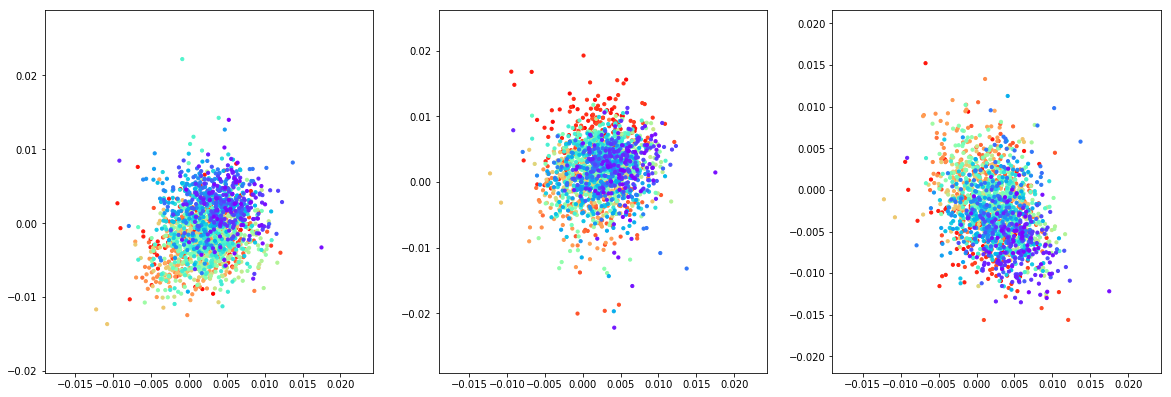

				  Average Log


In [215]:
show_embeds(np.array(average_codes).reshape(-1,4))
print('\t\t\t\t  Average Log')

In [127]:
top_codes = extract_code(top_news,10)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1000


In [128]:
hot_codes = extract_code(hot_news, 100)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [142]:
common_codes = extract_code(common_news, 10000)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


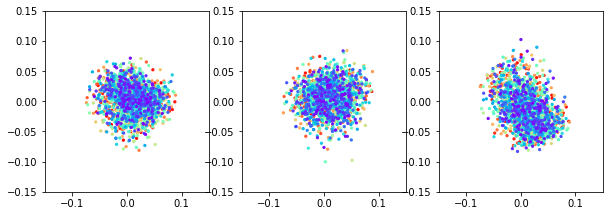

				   Top News


In [148]:
show_embeds(top_codes)
print('\t\t\t\t   Top News')

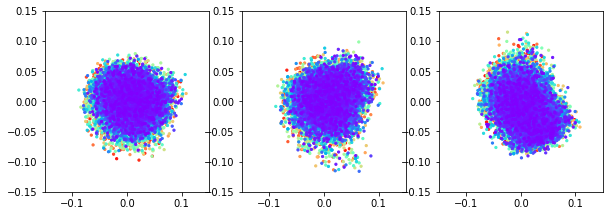

			      Hot News: ups>1000


In [149]:
show_embeds(hot_codes)
print('\t\t\t      Hot News: ups>1000')

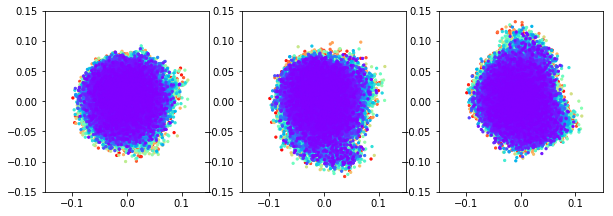

			      Common News: ups==0


In [150]:
show_embeds(common_codes)
print('\t\t\t      Common News: ups==0')